# Unsupervised Anomaly Detection using Vector Embeddings from Fine-Tuned DNS <U>doc2vec model</U>
1/22/2025, Dave Sisk, https://github.com/davidcsisk, https://www.linkedin.com/in/davesisk-doctordatabase/

This is a continuation of the prior research. In this notebook, we are leveraging the <u>Isolation Forest</u> algorithm to perform unsupervised training of an anomaly detection model, using text <u>vector embeddings</u> as the input. In this working example, we will use a doc2vec model that has been trained with the full contents of Wikipedia and then fine-tuned with DNS log data from secrepo.com.

In [11]:
### Uncomment and run the line below if this is the first time executing this notebook. Package installs in requirements.txt.
#! python -m venv venv
#! powershell venv\Scripts\Activate.ps1
#! pip install pandas 
#! pip install matplotlib
#! pip install scikit-learn
#! pip install gensim
#! pip install nltk
#import nltk
#nltk.download('punkt_tab')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models import Doc2Vec

<u>Notes</u>:

You can find a pre-trained and fine-tuned 200-dimension downloadable copy of the doc2vec DM (distributed memory algorithm) model here:
https://mega.nz/file/S2wxxArK#akoKdYl4SaO2JX29AHDWQ8skbDGnxrih9-mViK_ezWA   It's trained with the entire contents of Wikipedia, then fined tuned with DNS log data from SecRepo.com. The base DM doc2vec model performed somewhat acceptably on this task (it found 17 of 50 generated malicious proxy logs in a set of 950 benign logs and 50 malicious...I do not have malicious DNS log example available to me). Fine-tuning the DM model with DNS data improved it's performance by around 50-60%. Download and unzip in your working directory to use. If you would rather rebuild from scratch or with larger dimensionality, or fine-tune with different data, see the notebooks below instead.

I did not have public storage space available to store the fine-tuned DBOW (distributed bag of words) doc2vec model, but it did not perform acceptably for this anomaly detection task (my results showed it flagged every DNS log entry as an anomaly for this task, although it tested OK for non-DNS semantic similarity tasks).  I've commented-out all references to the DBOW model in this notebook...if you wish to try it yourself, reach out to me and we'll find some way to get that model to you. Or you can try fine-tuning it yourself using the base Wikipedia-trained DBOW model here: https://mega.nz/file/i6pVWQRD#gIdgXKJG5gEjRBZ2BDW_XlklBUtJb81a9EnlUrltnro  Note that both the base DBOW model and the fine-tuned DBOW model performed unacceptably for this DNS anomaly detection task, so that time is probably better spent elsewhere.

You can find the doc2vec model (both DM and DBOW) fine-tuning process here: 
https://github.com/davidcsisk/vector-search-with-security-logs/blob/main/fine-tune-doc2vec-model_dns-logs.ipynb

You can find the initial doc2vec training process (both DM and DBOW) on full wikipedia contents here: 
https://github.com/davidcsisk/vector-search-with-security-logs/blob/main/doc2vec-model-build_wikipedia-full-content.ipynb  You can find a downloadable copy of the 200-dimension doc2vec DM model trained on full Wikipedia contents but without the DNS fine-tuning here: https://mega.nz/file/ivwDmQYL#G1vmS8jJNpoDWf09mCspNsRzNzGFmqk1UPtTGjN7gBo

In [2]:
# Load pre-trained fine-tuned doc2vec model...this can take a minute or two
model_dm = Doc2Vec.load('doc2vec_wikipedia_dm_fine-tuned-on-dns.model')
#model_dbow = Doc2Vec.load('doc2vec_wikipedia_dbow_fine-tuned-on-dns.model')

In [3]:
# Do a test inference to see if the vector embedding looks like something we'd expect...so far, so good
new_doc = word_tokenize('UDP    www.example.com   IN   A    93.184.216.34 False')
# Try both
print('sample vector DM: ', model_dm.infer_vector(new_doc))
#print('sample vector DBOW: ', model_dbow.infer_vector(new_doc))

sample vector DM:  [ 2.31220853e-03 -5.85619081e-03 -4.40542179e-04  8.62247776e-03
  7.06677791e-04 -1.84771570e-03 -4.87006735e-03 -7.16725551e-03
 -3.70619469e-04  5.47282398e-03 -8.02405085e-03  9.27645830e-04
 -1.34245100e-04  3.31387087e-03 -5.15614869e-03 -1.08358562e-02
  6.09172788e-03 -1.65991415e-03 -1.05007710e-02 -1.06004840e-02
  8.26387294e-03 -7.53549021e-03 -5.05978009e-03  1.29263978e-02
  6.46760594e-03 -1.91811792e-04 -3.79562262e-04  1.15480938e-03
 -5.77733340e-03 -6.74628699e-03  8.26852955e-03  2.73557729e-03
  9.23666358e-03 -1.13991753e-03  1.31805334e-03 -3.37024394e-04
 -4.87240450e-03  1.36973755e-03  3.95305501e-03 -9.90911666e-03
  4.48062690e-03 -3.54492036e-03  1.43043255e-03  4.17413749e-03
  6.75535761e-03  8.51919584e-04 -2.40949122e-03  1.57063745e-03
  1.17716019e-03 -2.00703018e-03 -8.63358285e-03 -4.60126204e-03
 -5.12927026e-03 -2.71554524e-03  6.40220940e-03 -2.84496159e-03
 -1.57796603e-05 -2.33530649e-03 -4.12723701e-03 -1.54525484e-03
 -4.48

In [4]:
# We'll use DNS test data that we split from the full data set in the prior fine-tuning process. 
df = pd.read_csv('dns-log_test-data.csv')


,protocol,resolved_address,class,query_type,response,rejected
9269,udp,teredo.ipv6.microsoft.com,C_INTERNET,A,-,F
8008,udp,creativecommons.org,C_INTERNET,A,-,F
25138,udp,first.aprs.net,C_INTERNET,A,NXDOMAIN,F


In [5]:
# Preprocess a single row by concatenating all columns and tokenizing
def preprocess_dns_row(row):
    concatenated = ' '.join(map(str, row))  # Combine all column values as a single string
    tokens = concatenated.lower().split()  # Tokenize and convert to lowercase
    return tokens

# Create a new column for TaggedDocument objects in the DataFrame
df['TaggedDocument'] = [
    TaggedDocument(words=preprocess_dns_row(row), tags=[f"dns_{i}"])
    for i, row in df.iterrows()
]

In [6]:
# We'll use the pre-trained doc2vec model to calculate vector embeddings for these logs

# Apply infer_vector by extracting words from TaggedDocument
df['embedding_dm'] = df['TaggedDocument'].apply(lambda doc: model_dm.infer_vector(doc.words))
#df['embedding_dbow'] = df['TaggedDocument'].apply(lambda doc: model_dbow.infer_vector(doc.words))

df.sample(3)

,protocol,resolved_address,class,query_type,response,rejected,TaggedDocument,embedding_dm
19710,udp,time.apple.com,C_INTERNET,TXT,-,F,"([udp, time.apple.com, c_internet, txt, -, f],...","[4.3388456e-05, 0.0012334662, -0.00032489444, ..."
4620,udp,download.windowsupdate.com,C_INTERNET,A,-,F,"([udp, download.windowsupdate.com, c_internet,...","[0.00526383, -0.0074381577, 0.0003700002, 0.00..."
14383,udp,api.twitter.com,C_INTERNET,AAAA,-,F,"([udp, api.twitter.com, c_internet, aaaa, -, f...","[0.0035314667, -0.0060727177, -0.0009356215, 0..."


## Train Isolation Forest unsupervised model using the vector embeddings
We are doing semantic anomaly detection in this exercise.  The vector embeddings try to capture what the text content <i>means</i>, so applying isolation forest algorithm those numeric values will give us anomalies that <i>have a different meaning</i> than the norm.  The accuracy of this depends on how good the vector embeddings captured the meaning of the text content.

In [7]:
## Isolation Forest model using text embeddings from the DM model
# Define a model object with the Isolation Forest algorithm
iforest_dm_model=IsolationForest(n_estimators=100,max_samples=1000,contamination='auto',random_state=96)

# Convert the embedding column to a numpy array for input to IsolationForest...it's a little nit-picky here
X = np.vstack(df['embedding_dm'].values)

# Fit the data to the model
iforest_dm_model.fit(X)

# Display parameter values that were used
iforest_dm_model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 1000,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}

In [8]:
## DBOW model
# Define a model object with the Isolation Forest algorithm
#iforest_dbow_model=IsolationForest(n_estimators=100,max_samples=1000,contamination='auto',random_state=96)

# Convert the embedding column to a numpy array for input to IsolationForest...it's a little nit-picky here
#X = np.vstack(df['embedding_dbow'].values)

# Fit the data to the model
#iforest_dbow_model.fit(X)

# Display parameter values that were used
#iforest_dbow_model.get_params()

In [9]:
## DM
# Add a column to the DF for scores from the model's decision_function
df['raw_score_dm'] = iforest_dm_model.decision_function(X)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
df['anomaly_score_dm'] = iforest_dm_model.predict(X)

## DBOW
# Add a column to the DF for scores from the model's decision_function
#df['raw_score_dbow'] = iforest_dbow_model.decision_function(X)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
#df['anomaly_score_dbow'] = iforest_dbow_model.predict(X)


In [71]:
# Display the data with the columns added
df.sample(3)

,protocol,resolved_address,class,query_type,response,rejected,TaggedDocument,embedding_dm,raw_score_dm,anomaly_score_dm
11692,udp,teredo.ipv6.microsoft.com,C_INTERNET,A,-,F,"([udp, teredo.ipv6.microsoft.com, c_internet, ...","[-0.0015213316, -0.00479075, -0.0027627228, 0....",0.086841,1
4803,udp,fempdc3.fireeye.com,C_INTERNET,AAAA,-,F,"([udp, fempdc3.fireeye.com, c_internet, aaaa, ...","[0.0041774986, -0.0037285225, -0.0014912738, 0...",0.055221,1
22671,udp,COLLECTIVE,C_INTERNET,NB,-,F,"([udp, collective, c_internet, nb, -, f], [dns...","[-0.00083139335, -0.0057422887, -0.002347756, ...",0.046830,1


In [11]:
# The outliers have anomaly_score = -1 
print("DM: ", df['anomaly_score_dm'].value_counts())
#print("DBOW: ", df['anomaly_score_dbow'].value_counts())


DM:  anomaly_score_dm
 1    27347
-1      588
Name: count, dtype: int64


Interestingly enough, the DBOW (Distributed Bag of Words) model flagged every record as an anomaly...we saw similar behavior with generated proxy logs before the DBOW model was fine-tuned. The DM (Distributed Memory) model seems to be producing a more believable result, however. Perhaps this is why DM is the default algorithm, eh? Let's examine plots to gain some insight...

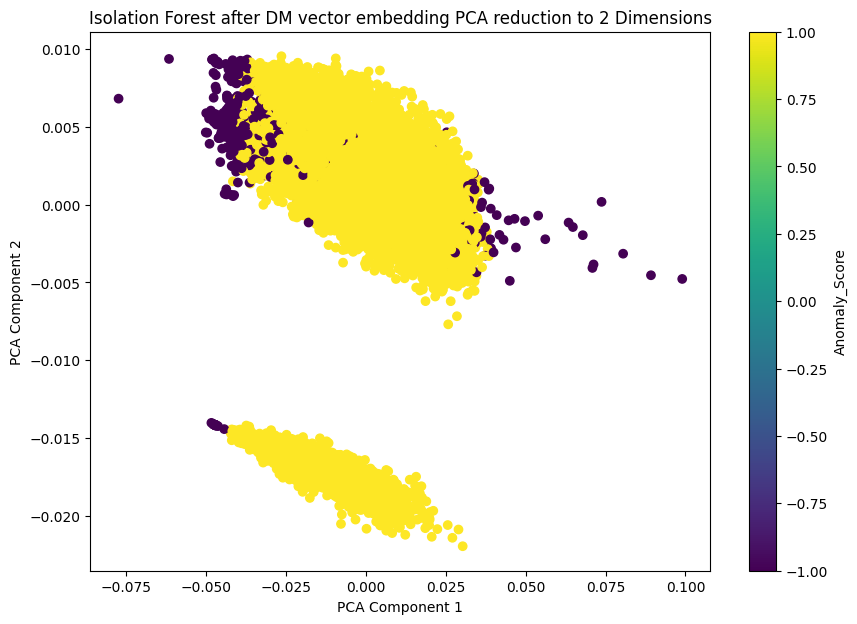

In [12]:
# Plot the results after applying PCA to the vector embeddings...color indicates the anomaly score.
# This is a bit like plotting two things to try to understand how/why they align/not...the dark colors are
# the samples that were flagged as anomalies.

## DM
# Reduce the 384 dimension vector embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
embeddings_dm = df['embedding_dm'].tolist()
reduced_embeddings_dm = pca.fit_transform(embeddings_dm)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings_dm[:, 0], reduced_embeddings_dm[:, 1], c=df['anomaly_score_dm'], cmap='viridis', marker='o')
plt.title('Isolation Forest after DM vector embedding PCA reduction to 2 Dimensions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Anomaly_Score')
plt.show()

# Judging from the plot, this appears to have done a decent job with the anomaly detection

## DBOW
# Reduce the 384 dimension vector embeddings to 2 dimensions using PCA
#pca = PCA(n_components=2)
#embeddings_dbow = df['embedding_dbow'].tolist()
#reduced_embeddings_dbow = pca.fit_transform(embeddings_dbow)

# Plot
#plt.figure(figsize=(10, 7))
#scatter = plt.scatter(reduced_embeddings_dbow[:, 0], reduced_embeddings_dbow[:, 1], c=df['anomaly_score_dbow'], cmap='viridis', marker='o')
#plt.title('Isolation Forest after DBOW vector embedding PCA reduction to 2 Dimensions')
#plt.xlabel('PCA Component 1')
#plt.ylabel('PCA Component 2')
#plt.colorbar(scatter, label='Anomaly_Score')
#plt.show()


The plot from the isolation forest model built from DM model embeddings looks believable, so I believe we can ignore DBOW for this task and just focus on leveraging DM model embeddings. We need to dig into why these records were flagged as anomalies. 

In [74]:
df[df['anomaly_score_dm'] == -1].sample(5)

,protocol,resolved_address,class,query_type,response,rejected,TaggedDocument,embedding_dm,raw_score_dm,anomaly_score_dm
16107,udp,time.apple.com,C_INTERNET,TXT,-,F,"([udp, time.apple.com, c_internet, txt, -, f],...","[0.0007174447, 0.0015012929, -0.0010447372, 0....",-0.033456,-1
10903,udp,51.229.168.192.in-addr.arpa,C_INTERNET,PTR,-,F,"([udp, 51.229.168.192.in-addr.arpa, c_internet...","[0.0039457167, -0.0058802483, -0.0011322083, 0...",-0.000739,-1
26094,udp,MACROMEDIA,C_INTERNET,NB,-,F,"([udp, macromedia, c_internet, nb, -, f], [dns...","[0.00552238, 0.002016812, -0.00017681294, -0.0...",-0.017752,-1
25099,udp,*\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\...,C_INTERNET,SRV,NOERROR,F,"([udp, *\x00\x00\x00\x00\x00\x00\x00\x00\x00\x...","[-0.0012757037, -0.0021142515, -0.0019898724, ...",-0.051235,-1
20431,udp,HPE8AA67,C_INTERNET,NB,-,F,"([udp, hpe8aa67, c_internet, nb, -, f], [dns_2...","[-0.0009048712, 0.0010290992, -0.0008724985, -...",-0.007506,-1


In [39]:
df_anomalies = df[df['anomaly_score_dm'] == -1]  # DF w/ anomalies only
df_normal = df[df['anomaly_score_dm'] == 1]  # DF w/ non-anomaly data


In [32]:
df_anomalies.sample(3)

,protocol,resolved_address,class,query_type,response,rejected,TaggedDocument,embedding_dm,raw_score_dm,anomaly_score_dm
23824,udp,253.21.168.192.in-addr.arpa,qclass-32769,PTR,NOERROR,F,"([udp, 253.21.168.192.in-addr.arpa, qclass-327...","[-0.00044374584, 0.0007676386, -0.0021013683, ...",-0.022373,-1
25842,udp,cf._dns-sd._udp.0.95.168.192.in-addr.arpa,C_INTERNET,TXT,REFUSED,T,"([udp, cf._dns-sd._udp.0.95.168.192.in-addr.ar...","[0.002689178, -0.0008790358, -0.0003088249, 0....",-0.010083,-1
2416,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,"([tcp, version.bind, c_chaos, txt, noerror, f]...","[-0.00079472753, -0.002637473, 0.0009744515, 0...",-0.026045,-1


In [34]:
# Summary statistics for original features
df_anomalies[['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']].describe(include='all')


,protocol,resolved_address,class,query_type,response,rejected
count,588,588,588,588,588,588
unique,2,171,4,10,5,2
top,udp,*\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\...,C_INTERNET,A,-,F
freq,570,108,544,131,370,516


In [38]:
# Most common values within each feature
for column in ['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']:
    print(f"FEATURE: {column}")
    print(df_anomalies[column].value_counts())
    print("\n")


FEATURE: protocol
protocol
udp    570
tcp     18
Name: count, dtype: int64


FEATURE: resolved_address
resolved_address
*\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00    108
MACROMEDIA                                                    40
time.apple.com                                                40
macromedia                                                    28
version.bind                                                  28
                                                            ... 
emr.ny.hec.net                                                 1
www.example.com                                                1
sql                                                            1
158.229.168.192.in-addr.arpa                                   1
192.168.21.25 192.168.22.25 192.168.23.25                      1
Name: count, Length: 171, dtype: int64


FEATURE: class
class
C_INTERNET      544
C_CHAOS          28
-                 9
qclass-32769      7
Name: count, dtype: int

In [42]:
# Compare feature distributions
for column in ['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']:
    print(f"Comparison for feature: {column}")
    print("ANOMALIES:")
    print(df_anomalies[column].value_counts())
    print("\nNORMAL:")
    print(df_normal[column].value_counts())
    print("\n")


Comparison for feature: protocol
ANOMALIES:
protocol
udp    570
tcp     18
Name: count, dtype: int64

NORMAL:
protocol
udp    27304
tcp       43
Name: count, dtype: int64


Comparison for feature: resolved_address
ANOMALIES:
resolved_address
*\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00    108
MACROMEDIA                                                    40
time.apple.com                                                40
macromedia                                                    28
version.bind                                                  28
                                                            ... 
emr.ny.hec.net                                                 1
www.example.com                                                1
sql                                                            1
158.229.168.192.in-addr.arpa                                   1
192.168.21.25 192.168.22.25 192.168.23.25                      1
Name: count, Length: 171, dtype: int64

NOR

The data in column 'resolved_address' seems to be the primary driver for classification as an anomaly, but combinations might also be a notable factor.  Let's dig a little deeper into examining the possible reasons for being flagged as an anomaly.

In [53]:
# Suppress certain warnings
# Suppress SettingWithCopyWarning globally within pandas
pd.set_option('mode.chained_assignment', None)


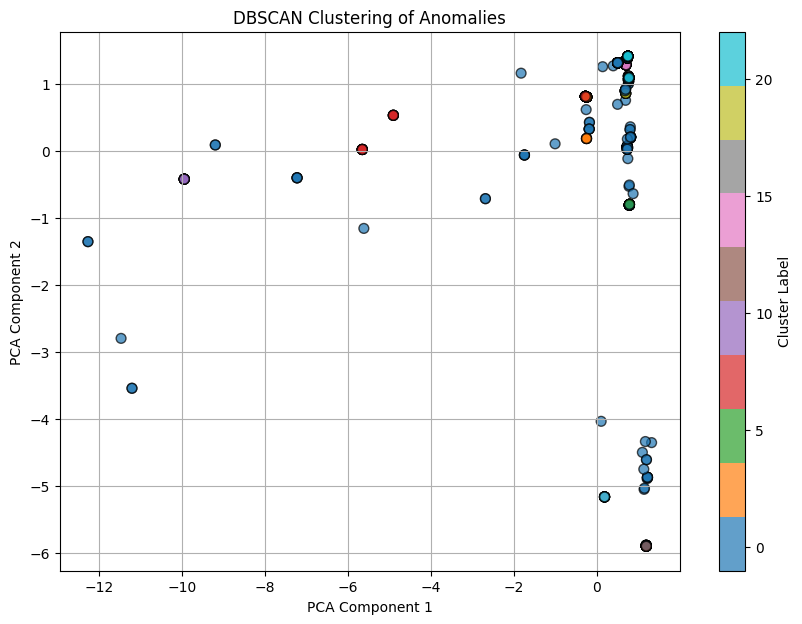

Number of clusters found by DBSCAN: 23
CLUSTER SIZES:
cluster
-1     231
 1      64
 2      44
 6      40
 21     40
 22     28
 13     19
 0      14
 5      11
 7      10
 9      10
 15     10
 17      7
 8       6
 10      6
 12      6
 14      6
 20      6
 4       5
 16      5
 18      5
 19      5
 3       5
 11      5
Name: count, dtype: int64

CLUSTER 0 ANALYSIS:
     protocol resolved_address       class query_type response rejected
125       udp             WPAD  C_INTERNET         NB        -        F
192       udp             WPAD  C_INTERNET         NB        -        F
638       udp             WPAD  C_INTERNET         NB        -        F
947       udp             WPAD  C_INTERNET         NB        -        F
6000      udp             WPAD  C_INTERNET         NB        -        F

CLUSTER 1 ANALYSIS:
    protocol                                   resolved_address       class  \
134      udp  *\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\...  C_INTERNET   
281      udp  *\

In [84]:
# Let's try DBSCAN clustering of the original features for the anomalies only
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Select the 6 original features
features = ['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']

# Step 1: One-Hot Encode Categorical Features
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_anomalies[features])

# Step 2: Standardize the Encoded Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(encoded_features)

# Step 3: Perform DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Adjust `eps` and `min_samples` as needed
dbscan_labels = dbscan.fit_predict(scaled_features)

# Add cluster labels to the anomalies dataframe
df_anomalies['cluster'] = dbscan_labels

# Step 4: Visualize with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create a scatter plot of the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pca_result[:, 0], 
    pca_result[:, 1], 
    c=dbscan_labels, 
    cmap='tab10', 
    s=50, 
    alpha=0.7, 
    edgecolors='k'
)
plt.colorbar(scatter, label='Cluster Label')
plt.title('DBSCAN Clustering of Anomalies')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

# Step 5: Print Number of Clusters
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters found by DBSCAN: {n_clusters}")

# Print the size of each cluster
cluster_sizes = df_anomalies['cluster'].value_counts()
print("CLUSTER SIZES:")
print(cluster_sizes)

# Step 5: Optional - Analyze Common Patterns in Each Cluster
for cluster_id in range(6):
    print(f"\nCLUSTER {cluster_id} ANALYSIS:")
    print(df_anomalies[df_anomalies['cluster'] == cluster_id][['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']].head())



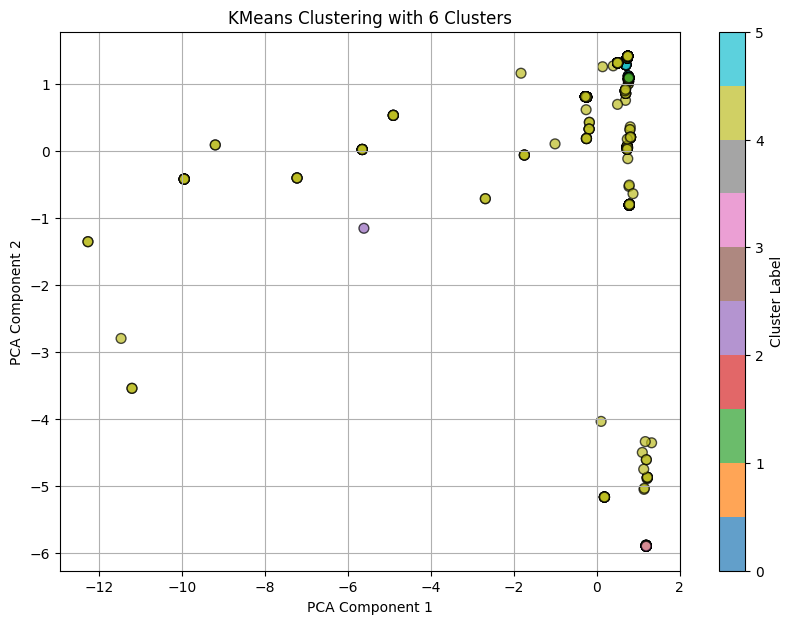

CLUSTER SIZES:
cluster_kmeans
4    517
1     28
0     19
5     17
3      6
2      1
Name: count, dtype: int64

CLUSTER 0 ANALYSIS:
     protocol           resolved_address       class query_type response  \
2999      udp  teredo.ipv6.microsoft.com  C_INTERNET          A        -   
3282      udp  teredo.ipv6.microsoft.com  C_INTERNET          A        -   
3522      udp  teredo.ipv6.microsoft.com  C_INTERNET          A        -   
4595      udp  teredo.ipv6.microsoft.com  C_INTERNET          A        -   
7655      udp  teredo.ipv6.microsoft.com  C_INTERNET          A        -   

     rejected  
2999        F  
3282        F  
3522        F  
4595        F  
7655        F  

CLUSTER 1 ANALYSIS:
      protocol resolved_address       class query_type response rejected
20705      udp       macromedia  C_INTERNET          A        -        F
20898      udp       macromedia  C_INTERNET          A        -        F
20957      udp       macromedia  C_INTERNET          A        -        F
212

In [83]:
# Let's try KMeans clustering with 6 groups (since there are 6 original features) for anomalies only
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Preprocess the data (One-Hot Encoding + Scaling)
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_anomalies[['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(encoded_features)

# Step 2: Apply KMeans with 6 Clusters
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the anomalies dataframe
df_anomalies['cluster_kmeans'] = kmeans_labels

# Step 3: Visualize the Clusters Using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=kmeans_labels,
    cmap='tab10',
    s=50,
    alpha=0.7,
    edgecolors='k'
)
plt.colorbar(scatter, label='Cluster Label')
plt.title('KMeans Clustering with 6 Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

# Step 4: Analyze Clusters
# Print the size of each cluster
cluster_sizes = df_anomalies['cluster_kmeans'].value_counts()
print("CLUSTER SIZES:")
print(cluster_sizes)

# Step 5: Optional - Analyze Common Patterns in Each Cluster
for cluster_id in range(6):
    print(f"\nCLUSTER {cluster_id} ANALYSIS:")
    print(df_anomalies[df_anomalies['cluster_kmeans'] == cluster_id][['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']].head())


The clustering exercises both seem to confirm that while there are multiple features involved in being flagged as an anomaly, the resolved_address is the biggest factor in that.  This is a very believable conclusion.  Let's look a little closer at some of the most anomalous rows (based on the decision_function() value from the Isolation Forest model).

In [77]:
# Show top 5 anomaly rows by largest (most negative) iforest_model.decision_function() raw score
df.sort_values(by='raw_score_dm', ascending=True).head(5)

,protocol,resolved_address,class,query_type,response,rejected,TaggedDocument,embedding_dm,raw_score_dm,anomaly_score_dm
25957,tcp,-,-,-,REFUSED,F,"([tcp, -, -, -, refused, f], [dns_25957])","[6.126714e-05, -3.361747e-05, 0.0017211519, 0....",-0.170996,-1
9703,udp,ubuntu.localdomain,C_INTERNET,MX,-,F,"([udp, ubuntu.localdomain, c_internet, mx, -, ...","[0.013631006, -0.017132917, -0.0002487598, 0.0...",-0.154891,-1
22345,udp,chase\xe2\x80\x99s macbook pro._sftp-ssh._tcp....,qclass-32769,*,-,F,"([udp, chase\xe2\x80\x99s, macbook, pro._sftp-...","[0.0019099695, -0.00031514256, 0.002185802, -0...",-0.143706,-1
8496,udp,ubuntu.localdomain,C_INTERNET,MX,-,F,"([udp, ubuntu.localdomain, c_internet, mx, -, ...","[0.006649281, -0.01483811, 0.00088727253, 0.01...",-0.131473,-1
8606,udp,ubuntu.localdomain,C_INTERNET,MX,-,F,"([udp, ubuntu.localdomain, c_internet, mx, -, ...","[0.008361303, -0.016140155, 4.953303e-05, 0.01...",-0.130403,-1


In [85]:
# Show all rows where the iforest_model.decision_function() raw anomaly score < -0.1
df[df['raw_score_dm'] < -0.1]

,protocol,resolved_address,class,query_type,response,rejected,TaggedDocument,embedding_dm,raw_score_dm,anomaly_score_dm
5903,udp,ubuntu.localdomain,C_INTERNET,A,-,F,"([udp, ubuntu.localdomain, c_internet, a, -, f...","[0.0034798016, -0.009072315, 0.00027744012, 0....",-0.100727,-1
8494,udp,ubuntu.localdomain,C_INTERNET,MX,-,F,"([udp, ubuntu.localdomain, c_internet, mx, -, ...","[0.006359619, -0.011783702, 0.0005722344, 0.01...",-0.109453,-1
8496,udp,ubuntu.localdomain,C_INTERNET,MX,-,F,"([udp, ubuntu.localdomain, c_internet, mx, -, ...","[0.006649281, -0.01483811, 0.00088727253, 0.01...",-0.131473,-1
8606,udp,ubuntu.localdomain,C_INTERNET,MX,-,F,"([udp, ubuntu.localdomain, c_internet, mx, -, ...","[0.008361303, -0.016140155, 4.953303e-05, 0.01...",-0.130403,-1
9700,udp,ubuntu.localdomain,C_INTERNET,MX,-,F,"([udp, ubuntu.localdomain, c_internet, mx, -, ...","[0.01015226, -0.010649743, 0.0032571277, 0.010...",-0.119324,-1
9703,udp,ubuntu.localdomain,C_INTERNET,MX,-,F,"([udp, ubuntu.localdomain, c_internet, mx, -, ...","[0.013631006, -0.017132917, -0.0002487598, 0.0...",-0.154891,-1
15162,udp,ubuntu.localdomain,C_INTERNET,MX,-,F,"([udp, ubuntu.localdomain, c_internet, mx, -, ...","[0.009084882, -0.0109475935, -0.0002111207, 0....",-0.104250,-1
22345,udp,chase\xe2\x80\x99s macbook pro._sftp-ssh._tcp....,qclass-32769,*,-,F,"([udp, chase\xe2\x80\x99s, macbook, pro._sftp-...","[0.0019099695, -0.00031514256, 0.002185802, -0...",-0.143706,-1
25957,tcp,-,-,-,REFUSED,F,"([tcp, -, -, -, refused, f], [dns_25957])","[6.126714e-05, -3.361747e-05, 0.0017211519, 0....",-0.170996,-1
27932,udp,192.168.21.25 192.168.22.25 192.168.23.25,C_INTERNET,A,NXDOMAIN,F,"([udp, 192.168.21.25, 192.168.22.25, 192.168.2...","[0.0068294047, -0.011732965, -0.0018151591, 0....",-0.121816,-1


While I'm quite certain that a modern text embedding LLM would produce better results via more accurate semantics of it's calculated vector embeddings, I believe this approach with a doc2vec model might be sufficiently accurate to produce at least some level of positive results. 